In [2]:
import pandas as pd

import geopandas as gpd
import pickle
from pysal.lib import weights # import weight lib
import statsmodels as sm
from sklearn.model_selection import train_test_split
import seaborn as sns

# Detector data

In [2]:
UTD19 = pd.read_csv('Data/detectors_public.csv') # read big file with all cities 
newcitylist= [ 'munich', 'rotterdam', 'frankfurt', 'hamburg', 'zurich'] # find only our cities for now, store in dataframe
UTD19Cities = UTD19.loc[UTD19.citycode.isin(newcitylist)] # UTD19Cities is dataframe

# Assigning Flow

In [3]:
data_frankfurt = pd.read_csv('data\\UTD_f.csv')
data_hamburg = pd.read_csv('data/UTD_h.csv')
data_munich = pd.read_csv('data\\UTD_m.csv')
data_rotterdam = pd.read_csv('data\\UTD_r.csv')
data_zurich = pd.read_csv('data\\UTD_z.csv')

In [4]:
frankfurt_detid_average = (data_frankfurt.groupby('detid').flow.mean()).to_frame(name = None)
hamburg_detid_average = (data_hamburg.groupby('detid').flow.mean()).to_frame(name = None)
munich_detid_average = (data_munich.groupby('detid').flow.mean()).to_frame(name = None)
rotterdam_detid_average = (data_rotterdam.groupby('detid').flow.mean()).to_frame(name = None)
zurich_detid_average = (data_zurich.groupby('detid').flow.mean()).to_frame(name = None)

In [5]:
frankfurt_detid_average['city'] = 'frankfurt'
hamburg_detid_average['city'] = 'hamburg'
munich_detid_average['city'] = 'munich'
rotterdam_detid_average['city'] =  'rotterdam'
zurich_detid_average['city'] = 'zurich'

In [80]:
frankfurt_detid_average.reset_index(inplace = True)
hamburg_detid_average.reset_index(inplace = True)
munich_detid_average.reset_index(inplace = True)
rotterdam_detid_average.reset_index(inplace = True)
zurich_detid_average.reset_index(inplace = True)

munich_detid_average['detid'] = munich_detid_average.detid.apply(str)

In [25]:
def Match(detid, df):
    if type(detid) == str:
        flowval = df.loc[df.detid == detid, 'flow'].values # get specific value
        try:
            flowval = float(flowval) # convert array to float
            return flowval
        except:
            # list empty
            return np.nan

In [74]:
MeanFlowDict = {
    'frankfurt':frankfurt_detid_average,
    'hamburg': hamburg_detid_average,
    'munich': munich_detid_average,
    'rotterdam': rotterdam_detid_average,
    'zurich': zurich_detid_average
}
MeanFlowDict['munich']

,detid,flow,city
0,4000011,243.825830,munich
1,4000012,217.739685,munich
2,4000013,216.527538,munich
3,4000014,187.267434,munich
4,4001011,208.219033,munich
...,...,...,...
515,11273001,187.943665,munich
516,11273002,135.409361,munich
517,11273004,34.447769,munich
518,11273005,97.515933,munich


In [122]:
def DetectorFrame(df = UTD19Cities, flodic = MeanFlowDict):
    DetDic = {}
    WDic = {}
    for city in df.citycode.unique():
        DF = gpd.GeoDataFrame(df.loc[df.citycode == city, ['detid','long','lat']])
        fl = flodic[city]
        DF['flow'] = DF.detid.apply(Match, args= [fl])
        DF['City'] = city
        DF['geometry'] = gpd.points_from_xy(DF['long'], DF['lat'])
        DF.drop(['long', 'lat'], inplace = True, axis = 1)
        DF.crs = 'EPSG:4326' # original (in decimal)
        DF = DF.to_crs('EPSG:4839') # in metres
        
        
        W= weights.distance.DistanceBand.from_dataframe(DF, threshold=250, ids='detid')
        NeighCount = lambda detid: len(W.neighbors[detid])
        DF['NeighCount'] = DF.detid.apply(NeighCount)  
        
        # store
        DetDic[city] = DF
        WDic[city] = W
        
    return DetDic, WDic
Df,weigthsPerCity = DetectorFrame()

C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 27 disconnected components.
 There are 3 islands with ids: K35D3.1, K148D3.5, K942D2.1.
  warnings.warn(message)
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 68 disconnected components.
 There are 4 islands with ids: 10599001, 10926001, 10939003, 10161005.
  warnings.warn(message)
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 61 disconnected components.
 There are 2 islands with ids: GRT02_MORO_1277_2_2, GRT02_MORO_1277

In [143]:
DetRot = Df['rotterdam']
DetRot.head()

,detid,flow,City,geometry,NeighCount
16321,GRT02_MORO_1811_2_1,392.931968,rotterdam,POINT (-409627.897 114878.047),1
16322,GRT02_MORO_1822_2_1,339.342356,rotterdam,POINT (-408094.756 114817.516),1
16323,GRT02_MORO_1293_2_1,385.277249,rotterdam,POINT (-413618.789 120024.077),2
16324,GRT02_MORO_1293_2_2,280.088515,rotterdam,POINT (-413618.789 120024.077),2
16325,GRT02_MORO_1851_2_1,342.891002,rotterdam,POINT (-411548.145 113917.160),10


In [94]:
## Load POI pickle
# Load data (deserialize)
with open('POI.pickle', 'rb') as handle:
    poi_dic = pickle.load(handle)

In [216]:
def FindType2(detid, wMatrix, typeToSearch, df):
    count = 0
    for i in wMatrix[detid].keys():
        x = df.loc[df.detid == i, 'poi_type'].item()
        if x == typeToSearch:
            count += 1

    return count 
    


In [236]:
# Functie doet er 40 mins over dus pak de pickle eronder
def ImportPOI(dic_poi = poi_dic, DetectorDataFrame = Df):
    RegressionDic = {}
    for key in dic_poi.keys():
        # loop through city
        poi_city = dic_poi[key]
        pois_def = poi_city[['geometry', 'poi_type', 'id']]
        pois_def.rename({'id':'detid'}, inplace = True, axis = 1)
        pois_def = pois_def.to_crs('EPSG:4839')
        
        pois_det = DetectorDataFrame[key].append(pois_def,ignore_index = True )
        
        
        
        W = weights.distance.DistanceBand.from_dataframe(pois_det, threshold=250, ids='detid')
        if bool(W.islands) == True:
            # there are islands remove and recalculate weights
            print ('Removing', len(W.islands), 'islands in:', key)
            for iterator in W.islands:
                pois_det = pois_det[pois_det.detid != iterator]
            # with islands removed -> recalc weigths
            W = weights.distance.DistanceBand.from_dataframe(pois_det, threshold = 250, ids='detid')
        
        
        NeighCount = lambda detid: len(W.neighbors[detid])
        pois_det['PoiNeighCount'] = pois_det.detid.apply(NeighCount)  
        pois_det['RealNeigh'] = pois_det['PoiNeighCount'] - pois_det['NeighCount']
        
        #FindType(W, pois_det)
        onlyDetectors = lambda Ids: 'Det' if type(Ids) == str else 'Poi'
        pois_det['c'] = pois_det.detid.apply(onlyDetectors)
        pois_det['poi_type'] = pois_det.poi_type.str.replace(' ', '')
        detectors = pois_det.loc[pois_det.c == 'Det']
        
        #print (pois_det.poi_type.unique())
        for ptype in pois_det.poi_type.unique():
            if type(ptype) == str:
                print ('started', ptype, 'in city ', key)
                detectors[ptype] = detectors.detid.apply(FindType2, args = [W, ptype, pois_det])
        detectors.drop(['poi_type','NeighCount','PoiNeighCount','c'], axis = 1, inplace = True)
        detectors.rename({'RealNeigh':'NeighboursTotal'}, axis = 1, inplace = True)
        RegressionDic[key] = detectors
        print ('finished in: ', key)
    return RegressionDic
        
%time rd = ImportPOI()    

C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\pandas\core\frame.py:4301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 8 islands with ids: 7327865, 137881875, 165817037, 200061317, 273610086, 495617279, 758327516, 9927671035.
  warnings.warn(message)


Removing 8 islands in: rotterdam


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


started station in city  rotterdam


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


started cycleway in city  rotterdam
started footway in city  rotterdam
started pedestrian in city  rotterdam
started footwayplatform in city  rotterdam


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


finished in:  rotterdam


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 29 disconnected components.
 There are 11 islands with ids: 14367218, 18091084, 20675700, 23544519, 27042734, 30488585, 30494960, 32618549, 89025679, 294254458, 700527307.
  warnings.warn(message)


Removing 11 islands in: munich


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  warnings.warn(message)


started station in city  munich
started footway in city  munich
started cycleway in city  munich
started pedestrian in city  munich
started footwayplatform in city  munich
finished in:  munich


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 23 disconnected components.
 There are 10 islands with ids: 28047109, 38586122, 88082746, 106530552, 365770976, 557366236, 601752437, 818866571, 819712895, 1872433481.
  warnings.warn(message)


Removing 10 islands in: zurich


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
  warnings.warn(message)


started station in city  zurich
started footway in city  zurich
started pedestrian in city  zurich
started cycleway in city  zurich
started footwayplatform in city  zurich
finished in:  zurich
started station in city  hamburg
started pedestrian in city  hamburg
started footway in city  hamburg
started cycleway in city  hamburg
started footwayplatform in city  hamburg
finished in:  hamburg
started station in city  frankfurt
started pedestrian in city  frankfurt
started footway in city  frankfurt
started cycleway in city  frankfurt
finished in:  frankfurt
Wall time: 40min 38s


In [240]:
rd['munich']

,detid,flow,City,geometry,NeighboursTotal,station,footway,cycleway,pedestrian,footwayplatform
0,10004022,254.610011,munich,POINT (80765.660 -318226.068),102.0,1,73,22,6,0
1,10004021,139.225395,munich,POINT (80761.979 -318223.897),103.0,1,74,22,6,0
2,4000011,243.825830,munich,POINT (83493.409 -315018.647),18.0,0,16,2,0,0
3,4000014,187.267434,munich,POINT (83485.299 -315013.987),18.0,0,16,2,0,0
4,4000012,217.739685,munich,POINT (83490.026 -315016.473),18.0,0,16,2,0,0
...,...,...,...,...,...,...,...,...,...,...
515,11012006,296.728696,munich,POINT (78304.903 -315652.949),57.0,2,52,3,0,0
516,11012005,240.409312,munich,POINT (78309.295 -315663.344),58.0,2,53,3,0,0
517,11180006,116.779234,munich,POINT (78740.438 -314198.768),56.0,0,49,6,1,0
518,11180005,91.541358,munich,POINT (78740.251 -314201.329),57.0,0,50,6,1,0


In [241]:
with open('RegressionDF.pickle', 'wb') as handle:
    pickle.dump(rd, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load Pickle detectors

In [3]:
with open('RegressionDF.pickle', 'rb') as handle:
    RegDf = pickle.load(handle)

In [4]:
RegDf['rotterdam']

,detid,flow,City,geometry,NeighboursTotal,station,cycleway,footway,pedestrian,footwayplatform
0,GRT02_MORO_1811_2_1,392.931968,rotterdam,POINT (-409627.897 114878.047),45.0,0,19,24,2,0
1,GRT02_MORO_1822_2_1,339.342356,rotterdam,POINT (-408094.756 114817.516),17.0,0,9,8,0,0
2,GRT02_MORO_1293_2_1,385.277249,rotterdam,POINT (-413618.789 120024.077),57.0,0,19,32,6,0
3,GRT02_MORO_1293_2_2,280.088515,rotterdam,POINT (-413618.789 120024.077),57.0,0,19,32,6,0
4,GRT02_MORO_1851_2_1,342.891002,rotterdam,POINT (-411548.145 113917.160),16.0,0,4,12,0,0
...,...,...,...,...,...,...,...,...,...,...
254,GRT02_MORO_1774_2_1,446.291149,rotterdam,POINT (-409106.593 115900.975),46.0,0,19,27,0,0
255,GRT02_MORO_1367_2_1,137.207754,rotterdam,POINT (-412158.230 118430.894),53.0,0,31,19,3,0
256,GRT02_MORO_1367_2_2,358.095099,rotterdam,POINT (-412158.230 118430.894),53.0,0,31,19,3,0
257,GRT02_MORO_1411_2_1,535.588881,rotterdam,POINT (-412215.181 121408.128),9.0,0,5,1,3,0


# OLS

In [5]:
Total = gpd.GeoDataFrame()
for i in RegDf.keys():
    ThisOne = RegDf[i]
    w = weights.distance.DistanceBand.from_dataframe(ThisOne, threshold = 250, ids='detid')
    if bool(w.islands) == True:
            # there are islands remove and recalculate weights
            print ('Removing', len(w.islands), 'islands in:',i)
            for iterator in w.islands:
                ThisOne = ThisOne[ThisOne.detid != iterator]
            # with islands removed -> recalc weigths
            w = weights.distance.DistanceBand.from_dataframe(ThisOne, threshold = 250, ids='detid')
            
    w.transform = 'R'
    ThisOne['Lag_Flow'] = weights.lag_spatial(w, ThisOne['flow'])
    
    Total = Total.append(ThisOne, ignore_index=True)

C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 61 disconnected components.
 There are 2 islands with ids: GRT02_MORO_1277_2_2, GRT02_MORO_1277_2_1.
  warnings.warn(message)
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 59 disconnected components.
  warnings.warn(message)
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 68 disconnected components.
 There are 4 islands with ids: 10599001, 10926001, 10939003, 10161005.
  warnings.warn(message)


Removing 2 islands in: rotterdam
Removing 4 islands in: munich


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 64 disconnected components.
  warnings.warn(message)
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 61 disconnected components.
 There are 3 islands with ids: K123D21, K34D11, K446D14.
  warnings.warn(message)
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 58 disconnected components.
  warnings.warn(message)


Removing 3 islands in: zurich
Removing 3 islands in: hamburg


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 27 disconnected components.
 There are 3 islands with ids: K35D3.1, K148D3.5, K942D2.1.
  warnings.warn(message)
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 24 disconnected components.
  warnings.warn(message)
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


In [6]:
Total

,detid,flow,City,geometry,NeighboursTotal,station,cycleway,footway,pedestrian,footwayplatform,Lag_Flow
0,GRT02_MORO_1811_2_1,392.931968,rotterdam,POINT (-409627.897 114878.047),45.0,0,19,24,2,0.0,352.676664
1,GRT02_MORO_1822_2_1,339.342356,rotterdam,POINT (-408094.756 114817.516),17.0,0,9,8,0,0.0,340.167520
2,GRT02_MORO_1293_2_1,385.277249,rotterdam,POINT (-413618.789 120024.077),57.0,0,19,32,6,0.0,307.186174
3,GRT02_MORO_1293_2_2,280.088515,rotterdam,POINT (-413618.789 120024.077),57.0,0,19,32,6,0.0,307.186174
4,GRT02_MORO_1851_2_1,342.891002,rotterdam,POINT (-411548.145 113917.160),16.0,0,4,12,0,0.0,229.296342
...,...,...,...,...,...,...,...,...,...,...,...
2313,STA2_D4(KFZ4),70.794979,frankfurt,POINT (-130952.381 -98513.752),32.0,0,2,30,0,NaN,228.490074
2314,STA1_D1(KFZ4),514.000000,frankfurt,POINT (-130978.227 -98382.916),30.0,0,2,28,0,NaN,199.996146
2315,STA1_D2(KFZ4),576.708333,frankfurt,POINT (-130981.138 -98384.956),30.0,0,2,28,0,NaN,193.725312
2316,STA1_D9(KFZ5),99.855596,frankfurt,POINT (-130941.286 -98365.248),30.0,0,2,28,0,NaN,241.410586


In [8]:
with open('NewTotal.pickle', 'wb') as handle:
    pickle.dump(Total, handle, protocol=pickle.HIGHEST_PROTOCOL)

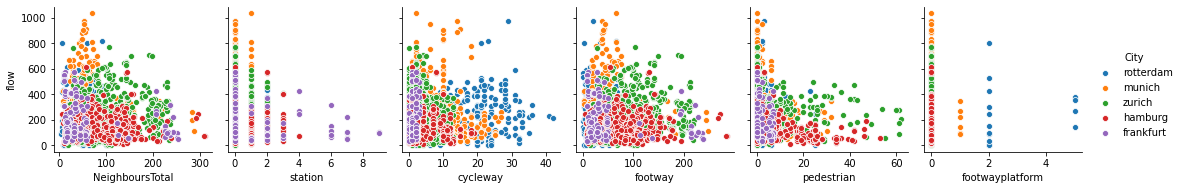

In [289]:
roffa = RegDf['rotterdam']
sns.pairplot(Total,
             x_vars=['NeighboursTotal', 'station','cycleway','footway', 'pedestrian','footwayplatform'], 
             y_vars = ['flow'],
            hue = 'City')

<AxesSubplot:ylabel='flow'>

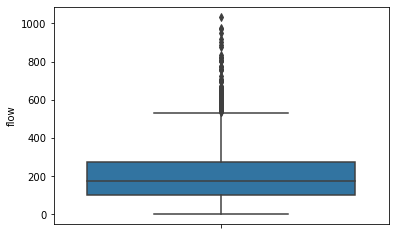

In [294]:
sns.boxplot(y = 'flow', data = Total)

In [255]:
roffa = RegDf['rotterdam']
regression(roffa['flow'], roffa['NeighboursTotal'], roffa)

Shape of the training set is (207, 10) and of the testing set is (52, 10).


KeyError: "None of [Float64Index([ 392.9319678127286,  339.3423555230432,  385.2772494513533,\n               280.0885149963424,  342.8910021945867, 28.040234089246525,\n              236.56547183613753,  502.4264813460132,  379.6349670811997,\n                93.2781693587862,\n              ...\n               472.8127286027798, 179.25822970007314,  207.3643013899049,\n                356.936356986101, 415.94220921726406, 446.29114850036575,\n              137.20775420629116,  358.0950987564009,  535.5888807607901,\n              216.77542062911485],\n             dtype='float64', length=259)] are in the [columns]"